# Modeling Influenza A Udorn (H3N2) in the resperatory tract of mice

This notebook plots the results of parameter optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=7)
palette

[(0.278826, 0.17549, 0.483397),
 (0.229739, 0.322361, 0.545706),
 (0.172719, 0.448791, 0.557885),
 (0.127568, 0.566949, 0.550556),
 (0.157851, 0.683765, 0.501686),
 (0.369214, 0.788888, 0.382914),
 (0.678489, 0.863742, 0.189503)]

## Data

In [7]:
# Data in log scale
df = pd.read_csv('data/viral_load.csv')
df

,Day,nose,stdN,trachea,stdT,lung,stdL
0,1,4.12033,0.85892,1.44097,0.47830,1.00111,0.02002
1,2,5.07884,0.63485,3.60242,0.58729,2.36263,0.94104
2,3,3.94606,0.35477,4.69828,0.69022,3.21023,1.58844
3,4,4.51867,0.15560,4.64379,0.90212,4.07119,1.40823
4,5,4.48133,0.58506,4.14127,1.15641,2.14238,1.48165
5,6,3.67220,0.22407,2.61554,0.36327,4.41157,0.26696
6,7,3.23029,0.27386,0.99899,0.02422,1.14127,0.32035
7,8,1.16390,0.23029,0.99899,0.01816,0.99444,0.02002


In [51]:
dfCD8 = pd.read_csv('data/cd8_h3n2.csv')
dfCD8

,Day,Trachea,Lungs
0,6,7188,2288802
1,8,10614,4685658
2,10,10520,1943025
3,14,4637,1495088


In [9]:
parNames=['V0',
          'bet1', 'xi1', 'chi1', 'del1', 'rho1', 'sig1',
          'bet2', 'xi2', 'chi2', 'psi2', 'del2', 'rho2', 'sig2', 'eta2', 'kap2', 'ups2',
          'bet3', 'xi3', 'chi3', 'psi3', 'del3', 'rho3', 'sig3', 'eta3', 'kap3', 'ups3',
          'gam12', 'gam21', 'gam23', 'gam32', 'zet23', 'zet32']

# There's a discrepancy in the name of some parameters
# between the paper and how I handled in the codes,
# here the equivalencies:
# rho -> p
# sig -> c

## Functions

In [16]:
def safeLog10(x, eps=1e-8):
    return np.log10(x + eps)

In [25]:
def unpack_params(params):
    ii = 1  # skip first param if needed

    # Compartment 1
    bet1, xi1, chi1, del1, rho1, sig1, alp1, phi1 = params[ii:ii+8]
    ii += 8

    # Compartment 2
    bet2, xi2, chi2, psi2, del2, rho2, sig2, alp2, phi2, eta2, kap2, ups2 = params[ii:ii+12]
    ii += 12

    # Compartment 3
    bet3, xi3, chi3, psi3, del3, rho3, sig3, alp3, phi3, eta3, kap3, ups3 = params[ii:ii+12]
    ii += 12

    # Transfer rates
    gam12, gam21, gam23, gam32, zet23, zet32 = params[ii:ii+6]

    return {
        'bet1': bet1, 'xi1': xi1, 'chi1': chi1, 'del1': del1, 'rho1': rho1, 'sig1': sig1, 'alp1': alp1, 'phi1': phi1,
        'bet2': bet2, 'xi2': xi2, 'chi2': chi2, 'psi2': psi2, 'del2': del2, 'rho2': rho2, 'sig2': sig2, 'alp2': alp2,
        'phi2': phi2, 'eta2': eta2, 'kap2': kap2, 'ups2': ups2,
        'bet3': bet3, 'xi3': xi3, 'chi3': chi3, 'psi3': psi3, 'del3': del3, 'rho3': rho3, 'sig3': sig3, 'alp3': alp3,
        'phi3': phi3, 'eta3': eta3, 'kap3': kap3, 'ups3': ups3,
        'gam12': gam12, 'gam21': gam21, 'gam23': gam23, 'gam32': gam32, 'zet23': zet23, 'zet32': zet32
    }

## Model 1:

**Nose**:
$$\dot{U_1} = -\beta_1 U_1 V_1$$
$$\dot{I_1} = \beta_1 U_1 V_1 - \delta_1 I_1$$
$$\dot{V_1} = \rho_1 I_1 - \varsigma_1 V_1 - \gamma_{12}V_1 + \gamma_{21}V_2$$

**Trachea**:
$$\dot{U_2} = -\beta_2 U_2 V_2$$
$$\dot{I_2} = \beta_2 U_2 V_2 - \delta_2 I_2$$
$$\dot{V_2} = \rho_2 I_2 - \varsigma_2 V_2 - \gamma_{21}V_2 + \gamma_{12}V_1 - \gamma_{23}V_2 + \gamma_{32}V_3$$

**Lung**:
$$\dot{U_3} = -\beta_3 U_3 V_3$$
$$\dot{I_3} = \beta_3 U_3 V_3 - \psi_3 I_3 T_3$$
$$\dot{V_3} = \rho_3 I_3 - \varsigma_3 V_3 - \gamma_{32}V_3 + \gamma_{23}V_2$$

In [22]:
params = np.loadtxt('data/bestPars_M1.dat', comments='#')
for i in range(len(parNames)):
    print(f'{parNames[i]} = {params[i]}')

V0 = 5.645105
bet1 = 1e-08
xi1 = 0.0
chi1 = 0.0
del1 = 8.95576
rho1 = 0.01
sig1 = 1.879889
bet2 = 0.0
xi2 = 0.0
chi2 = 1.912606e-05
psi2 = 0.0
del2 = 0.0
rho2 = 0.0
sig2 = 4.372808
eta2 = 0.01
kap2 = 7.89224
ups2 = 0.0
bet3 = 0.0
xi3 = 0.0
chi3 = 0.0
psi3 = 0.0
del3 = 5.782555e-06
rho3 = 0.0
sig3 = 0.0
eta3 = 0.0
kap3 = 6.494539
ups3 = 0.01
gam12 = 8.318066
gam21 = 0.0
gam23 = 0.0
gam32 = 0.0
zet23 = 0.0
zet32 = 0.0


In [33]:
def model1(y, t, params):
    p = unpack_params(params)
    
    U1, I1, V1, U2, I2, V2, U3, I3, V3 = y

    dU1 = -p['bet1']*U1*V1
    dI1 = p['bet1']*U1*V1 - p['del1']*I1
    dV1 = p['rho1']*I1 - p['sig1']*V1 - p['gam12']*V1 + p['gam21']*V2

    dU2 = -p['bet2']*U2*V2
    dI2 = p['bet2']*U2*V2 - p['del2']*I2
    dV2 = p['rho2']*I2 - p['sig2']*V2 - p['gam21']*V2 + p['gam12']*V1 - p['gam23']*V2 + p['gam32']*V3

    dU3 = -p['bet3']*U3*V3
    dI3 = p['bet3']*U3*V3 - p['del3']*I3
    dV3 = p['rho3']*I3 - p['sig3']*V3 - p['gam32']*V3 + p['gam23']*V2
    
    return [dU1, dI1, dV1, dU2, dI2, dV2, dU3, dI3, dV3]

In [30]:
U10, U20, U30 = 5e8, 5e8, 5e8
I10, I20, I30 = 0.0, 0.0, 0.0
V10, V20, V30 = 10**params[0], 0.0, 0.0
initState = [U10, I10, V10, U20, I20, V20, U30, I30, V30]
    
timeStep = 0.1
endDay = 10
tt = np.arange(0, endDay, timeStep)

levels = odeint(model1, initState, tt, args=(params,))

UU1 = levels[:,0]
II1 = levels[:,1]
VV1 = levels[:,2]

UU2 = levels[:,3]
II2 = levels[:,4]
VV2 = levels[:,5]

UU3 = levels[:,6]
II3 = levels[:,7]
VV3 = levels[:,8]

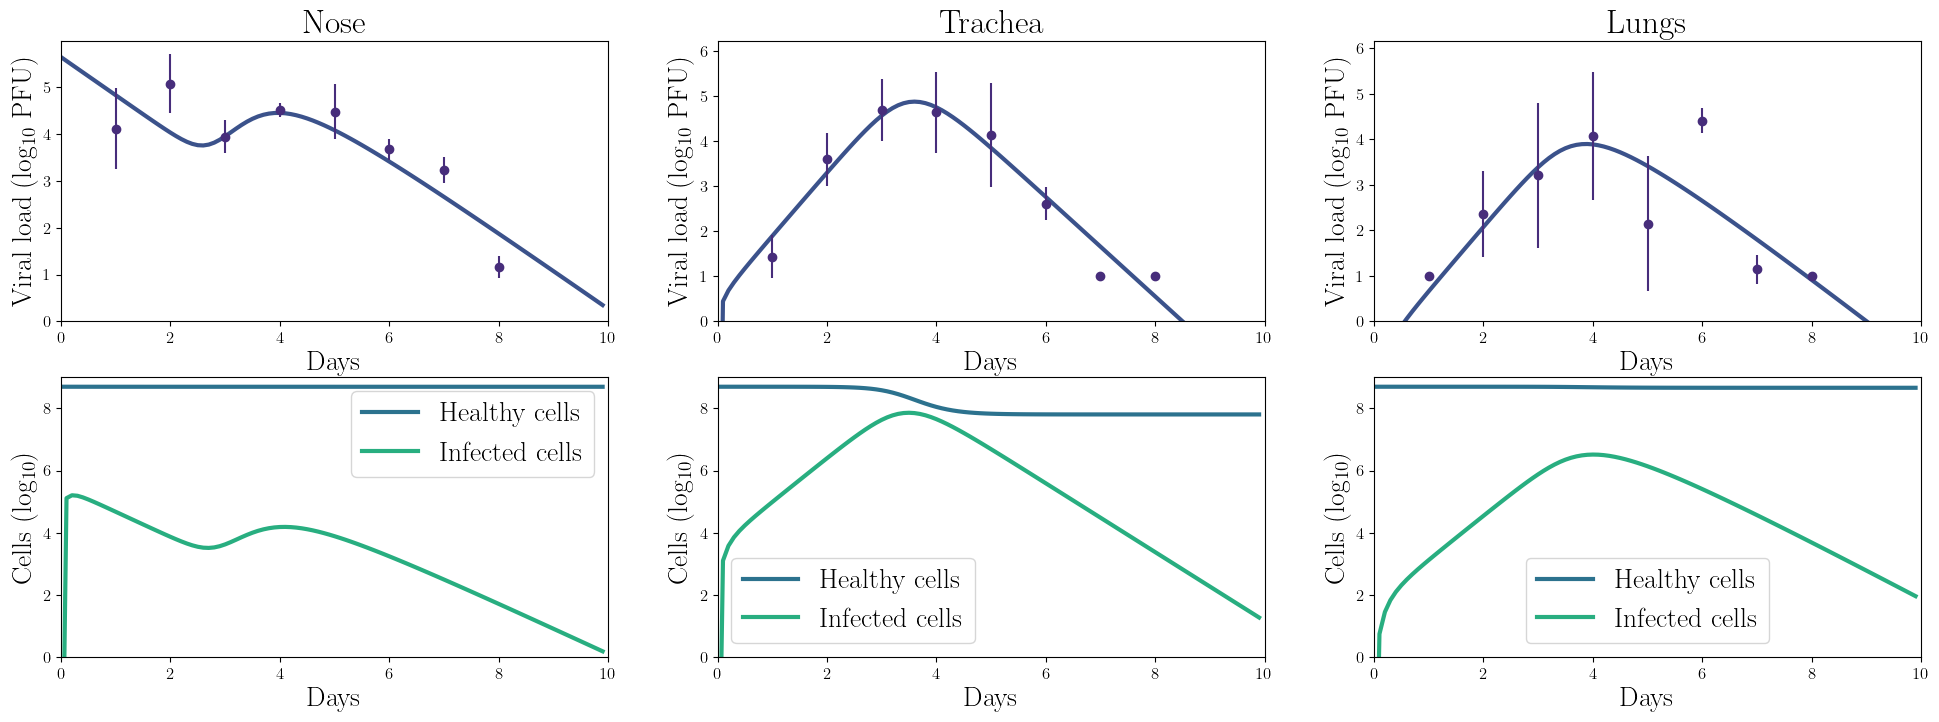

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,8), facecolor='white')

# Nose
axs[0,0].set_title('Nose')
axs[0,0].plot(tt, safeLog10(VV1), lw=3, color=palette[1])
axs[0,0].errorbar(x=df['Day'], y=df['nose'], yerr=df['stdN'], fmt='o', color=palette[0])
axs[0,0].set_ylim((0))
axs[0,0].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,0].plot(tt, safeLog10(UU1), lw=3, color=palette[2], label='Healthy cells')
axs[1,0].plot(tt, safeLog10(II1), lw=3, color=palette[4], label='Infected cells')
axs[1,0].set_ylim((0, 9))
axs[1,0].set_ylabel('Cells (log$_{10}$)')
axs[1,0].legend()

# Trachea
axs[0,1].set_title('Trachea')
axs[0,1].plot(tt, safeLog10(VV2), lw=3, color=palette[1])
axs[0,1].errorbar(df['Day'], df['trachea'], yerr=df['stdT'], fmt='o', color=palette[0])
axs[0,1].set_ylim((0))
axs[0,1].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,1].plot(tt, safeLog10(UU2), lw=3, color=palette[2], label='Healthy cells')
axs[1,1].plot(tt, safeLog10(II2), lw=3, color=palette[4], label='Infected cells')
axs[1,1].set_ylim((0, 9))
axs[1,1].set_ylabel('Cells (log$_{10}$)')
axs[1,1].legend()

# Lungs
axs[0,2].set_title('Lungs')
axs[0,2].plot(tt, safeLog10(VV3), lw=3, color=palette[1])
axs[0,2].errorbar(df['Day'], df['lung'], yerr=df['stdL'], fmt='o', color=palette[0])
axs[0,2].set_ylim((0))
axs[0,2].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,2].plot(tt, safeLog10(UU3), lw=3, color=palette[2], label='Healthy cells')
axs[1,2].plot(tt, safeLog10(II3), lw=3, color=palette[4], label='Infected cells')
axs[1,2].set_ylim((0, 9))
axs[1,2].set_ylabel('Cells (log$_{10}$)')
axs[1,2].legend()

plt.setp(axs, xlim=(0,endDay), xlabel='Days')

# plt.savefig('M1_fit.pdf')

plt.show()

## Model 2:

**Nose**:
$$\dot{U_1} = -\beta_1 U_1 V_1 - \xi_1 U_1 I_1$$
$$\dot{I_1} = \beta_1 U_1 V_1 - \delta_1 I_1$$
$$\dot{R_1} = \xi_1 U_1 I_1$$
$$\dot{V_1} = \rho_1 I_1 - \varsigma_1 V_1 - \gamma_{12}V_1 + \gamma_{21}V_2$$

**Trachea**:
$$\dot{U_2} = -\beta_2 U_2 V_2 - \xi_2 U_2 I_2$$
$$\dot{I_2} = \beta_2 U_2 V_2 - \delta_2 I_2$$
$$\dot{R_2} = \xi_2 U_2 I_2$$
$$\dot{V_2} = \rho_2 I_2 - \varsigma_2 V_2 - \gamma_{21}V_2 + \gamma_{12}V_1 - \gamma_{23}V_2 + \gamma_{32}V_3$$

**Lungs**:
$$\dot{U_3} = -\beta_3 U_3 V_3 -\xi_3 U_3 I_3$$
$$\dot{I_3} = \beta_3 U_3 V_3 - \delta_3 I_3$$
$$\dot{R_3} = \xi_3 U_3 I_3$$
$$\dot{V_3} = \rho_3 I_3 - \varsigma_3 V_3 - \gamma_{32}V_3 + \gamma_{23}V_2$$

In [34]:
params = np.loadtxt('data/bestPars_M2.dat', comments='#')
for i in range(len(parNames)):
    print(f'{parNames[i]} = {params[i]}')

V0 = 5.644021
bet1 = 8.936738e-08
xi1 = 6.556899e-05
chi1 = 0.0
del1 = 9.338948
rho1 = 0.01
sig1 = 1.818836
bet2 = 0.0
xi2 = 0.0
chi2 = 1.455119e-05
psi2 = 1.935001e-08
del2 = 0.0
rho2 = 0.0
sig2 = 4.259297
eta2 = 0.01
kap2 = 3.764441
ups2 = 0.0
bet3 = 0.0
xi3 = 0.0
chi3 = 0.0
psi3 = 0.0
del3 = 1.984014e-05
rho3 = 0.0001
sig3 = 0.0
eta3 = 0.0
kap3 = 5.381512
ups3 = 0.01
gam12 = 2.174085
gam21 = 0.0
gam23 = 0.0
gam32 = 0.0
zet23 = 0.0
zet32 = 0.0


In [35]:
def model2(y, t, params):
    p = unpack_params(params)

    U1, I1, R1, V1, U2, I2, R2, V2, U3, I3, R3, V3 = y

    dU1 = -p['bet1']*U1*V1 - p['xi1']*U1*I1
    dI1 = p['bet1']*U1*V1 - p['del1']*I1
    dR1 = p['xi1']*U1*I1
    dV1 = p['rho1']*I1 - p['sig1']*V1 - p['gam12']*V1 + p['gam21']*V2

    dU2 = -p['bet2']*U2*V2 - p['xi2']*U2*I2
    dI2 = p['bet2']*U2*V2 - p['del2']*I2
    dR2 = p['xi2']*U2*I2
    dV2 = p['rho2']*I2 - p['sig2']*V2 - p['gam21']*V2 + p['gam12']*V1 - p['gam23']*V2 + p['gam32']*V3

    dU3 = -p['bet3']*U3*V3 - p['xi3']*U3*I3
    dI3 = p['bet3']*U3*V3 - p['del3']*I3
    dR3 = p['xi3']*U3*I3
    dV3 = p['rho3']*I3 - p['sig3']*V3 - p['gam32']*V3 + p['gam23']*V2

    return [dU1, dI1, dR1, dV1, dU2, dI2, dR2, dV2, dU3, dI3, dR3, dV3]


In [37]:
U10, U20, U30 = 5e8, 5e8, 5e8
I10, I20, I30 = 0.0, 0.0, 0.0
R10, R20, R30 = 0.0, 0.0, 0.0
V10, V20, V30 = 10**params[0], 0.0, 0.0
initState = [U10, I10, R10, V10, U20, I20, R20, V20, U30, I30, R30, V30]
    
timeStep = 0.01
endDay = 12
tt = np.arange(0, endDay, timeStep)

levels = odeint(model2, initState, tt, args=(params,))

UU1 = levels[:,0]
II1 = levels[:,1]
RR1 = levels[:,2]
VV1 = levels[:,3]

UU2 = levels[:,4]
II2 = levels[:,5]
RR2 = levels[:,6]
VV2 = levels[:,7]

UU3 = levels[:,8]
II3 = levels[:,9]
RR3 = levels[:,10]
VV3 = levels[:,11]

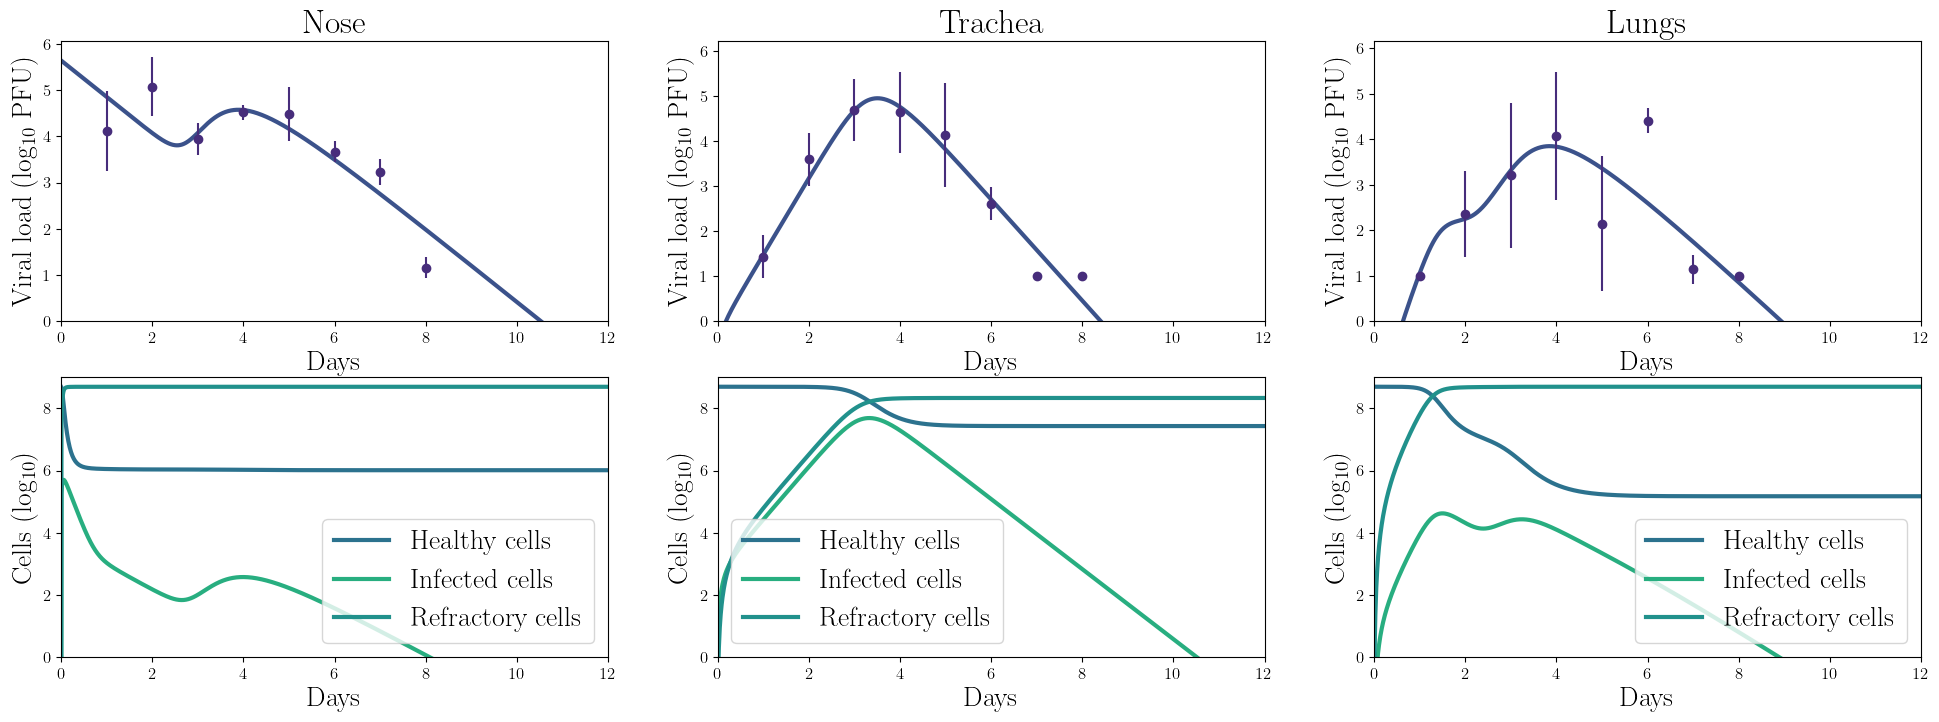

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(24,8), facecolor='white')

# Nose
axs[0,0].set_title('Nose')
axs[0,0].plot(tt, safeLog10(VV1), lw=3, color=palette[1])
axs[0,0].errorbar(x=df['Day'], y=df['nose'], yerr=df['stdN'], fmt='o', color=palette[0])
axs[0,0].set_ylim((0))
axs[0,0].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,0].plot(tt, safeLog10(UU1), lw=3, color=palette[2], label='Healthy cells')
axs[1,0].plot(tt, safeLog10(II1), lw=3, color=palette[4], label='Infected cells')
axs[1,0].plot(tt, safeLog10(RR1), lw=3, color=palette[3], label='Refractory cells')
axs[1,0].set_ylim((0, 9))
axs[1,0].set_ylabel('Cells (log$_{10}$)')
axs[1,0].legend()

# Trachea
axs[0,1].set_title('Trachea')
axs[0,1].plot(tt, safeLog10(VV2), lw=3, color=palette[1])
axs[0,1].errorbar(df['Day'], df['trachea'], yerr=df['stdT'], fmt='o', color=palette[0])
axs[0,1].set_ylim((0))
axs[0,1].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,1].plot(tt, safeLog10(UU2), lw=3, color=palette[2], label='Healthy cells')
axs[1,1].plot(tt, safeLog10(II2), lw=3, color=palette[4], label='Infected cells')
axs[1,1].plot(tt, safeLog10(RR2), lw=3, color=palette[3], label='Refractory cells')
axs[1,1].set_ylim((0, 9))
axs[1,1].set_ylabel('Cells (log$_{10}$)')
axs[1,1].legend()

# Lungs
axs[0,2].set_title('Lungs')
axs[0,2].plot(tt, safeLog10(VV3), lw=3, color=palette[1])
axs[0,2].errorbar(df['Day'], df['lung'], yerr=df['stdL'], fmt='o', color=palette[0])
axs[0,2].set_ylim((0))
axs[0,2].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,2].plot(tt, safeLog10(UU3), lw=3, color=palette[2], label='Healthy cells')
axs[1,2].plot(tt, safeLog10(II3), lw=3, color=palette[4], label='Infected cells')
axs[1,2].plot(tt, safeLog10(RR3), lw=3, color=palette[3], label='Refractory cells')
axs[1,2].set_ylim((0, 9))
axs[1,2].set_ylabel('Cells (log$_{10}$)')
axs[1,2].legend()

plt.setp(axs, xlim=(0,endDay), xlabel='Days')

# plt.savefig('M2_fit.pdf')

plt.show()

## Model 3:

**Nose**:
$$\dot{U_1} = -\beta_1 U_1 V_1$$
$$\dot{I_1} = \beta_1 U_1 V_1 - \delta_1 I_1$$
$$\dot{V_1} = \rho_1 I_1 - \varsigma_1 V_1 - \gamma_{12}V_1 + \gamma_{21}V_2$$

**Trachea**:
$$\dot{U_2} = -\beta_2 U_2 V_2$$
$$\dot{I_2} = \beta_2 U_2 V_2 - \delta_2 I_2 - \psi_2 I_2 T_2$$
$$\dot{V_2} = \rho_2 I_2 - \varsigma_2 V_2 - \gamma_{21}V_2 + \gamma_{12}V_1 - \gamma_{23}V_2 + \gamma_{32}V_3$$
$$\dot{T_2} = \eta_2 T_2 \left( \frac{V_2^2}{V_2^2 + \kappa_2^2} \right) - \upsilon_2 T_2 + \upsilon_2 T_0 - \zeta_{23} T_2 + \zeta_{32} T_3$$

**Lungs**:
$$\dot{U_3} = -\beta_3 U_3 V_3$$
$$\dot{I_3} = \beta_3 U_3 V_3 - \delta_3 I_3 - \psi_3 I_3 T_3$$
$$\dot{V_3} = \rho_3 I_3 - \varsigma_3 V_3 - \gamma_{32}V_3 + \gamma_{23}V_2$$
$$\dot{T_3} = \eta_3 T_3 \left( \frac{V_3^2}{V_3^2 + \kappa_3^2} \right) - \upsilon_3 T_3 + \upsilon_3 T_0 - \zeta_{32} T_3 + \zeta_{23} T_2$$

In [40]:
params = np.loadtxt('data/bestPars_M3.dat', comments='#')
for i in range(len(parNames)):
    print(f'{parNames[i]} = {params[i]}')

V0 = 5.945975
bet1 = 7.251551e-07
xi1 = 0.0
chi1 = 0.0
del1 = 7.023197
rho1 = 0.01
sig1 = 2.371068
bet2 = 0.0
xi2 = 0.0
chi2 = 1.625488e-05
psi2 = 0.0
del2 = 0.0
rho2 = 0.0
sig2 = 5.609623
eta2 = 0.01
kap2 = 4.823887
ups2 = 0.0
bet3 = 0.0
xi3 = 0.9327819
chi3 = 100000.0
psi3 = 0.9962713
del3 = 3.646889e-06
rho3 = 0.0
sig3 = 0.0
eta3 = 0.0
kap3 = 9.133912
ups3 = 0.01
gam12 = 4.804927
gam21 = 0.0
gam23 = 0.0
gam32 = 0.8878485
zet23 = 3108.45
zet32 = 0.538928


In [47]:
def model3(y, t, params):
    p = unpack_params(params)

    T20 = 1e6
    T30 = 1e6

    U1, I1, V1, U2, I2, V2, T2, U3, I3, V3, T3 = y

    dU1 = -p['bet1']*U1*V1
    dI1 = p['bet1']*U1*V1 - p['del1']*I1
    dV1 = p['rho1']*I1 - p['sig1']*V1 - p['gam12']*V1 + p['gam21']*V2
    
    dU2 = -p['bet2']*U2*V2
    dI2 = p['bet2']*U2*V2 - p['psi2']*I2*T2 - p['del2']*I2
    dV2 = p['rho2']*I2 - p['sig2']*V2 - p['gam21']*V2 + p['gam12']*V1 - p['gam23']*V2 + p['gam32']*V3
    dT2 = p['eta2']*T2*(V2**2/(V2**2 + p['kap2']**2)) - p['ups2']*T2 + p['ups2']*T30 - p['zet23']*T2 + p['zet32']*T3
    
    dU3 = -p['bet3']*U3*V3
    dI3 = p['bet3']*U3*V3 - p['psi3']*I3*T3 - p['del3']*I3
    dV3 = p['rho3']*I3 - p['sig3']*V3 - p['gam32']*V3 + p['gam23']*V2
    dT3 = p['eta3']*T3*(V3**2/(V3**2 + p['kap3']**2)) - p['ups3']*T3 + p['ups3']*T30 - p['zet32']*T3 + p['zet23']*T2

    return [dU1, dI1, dV1, dU2, dI2, dV2, dT2, dU3, dI3, dV3, dT3]

In [48]:
U10, U20, U30 = 5e8, 5e8, 5e8
I10, I20, I30 = 0.0, 0.0, 0.0
V10, V20, V30 = 10**params[0], 0.0, 0.0
T20, T30 = 1e6, 1e6
initState = [U10, I10, V10, U20, I20, V20, T20, U30, I30, V30, T30]
    
timeStep = 0.1
endDay = 10
tt = np.arange(0, endDay, timeStep)

levels = odeint(model3, initState, tt, args=(params,))

UU1 = levels[:,0]
II1 = levels[:,1]
VV1 = levels[:,2]

UU2 = levels[:,3]
II2 = levels[:,4]
VV2 = levels[:,5]
TT2 = levels[:,6]

UU3 = levels[:,7]
II3 = levels[:,8]
VV3 = levels[:,9]
TT3 = levels[:,10]

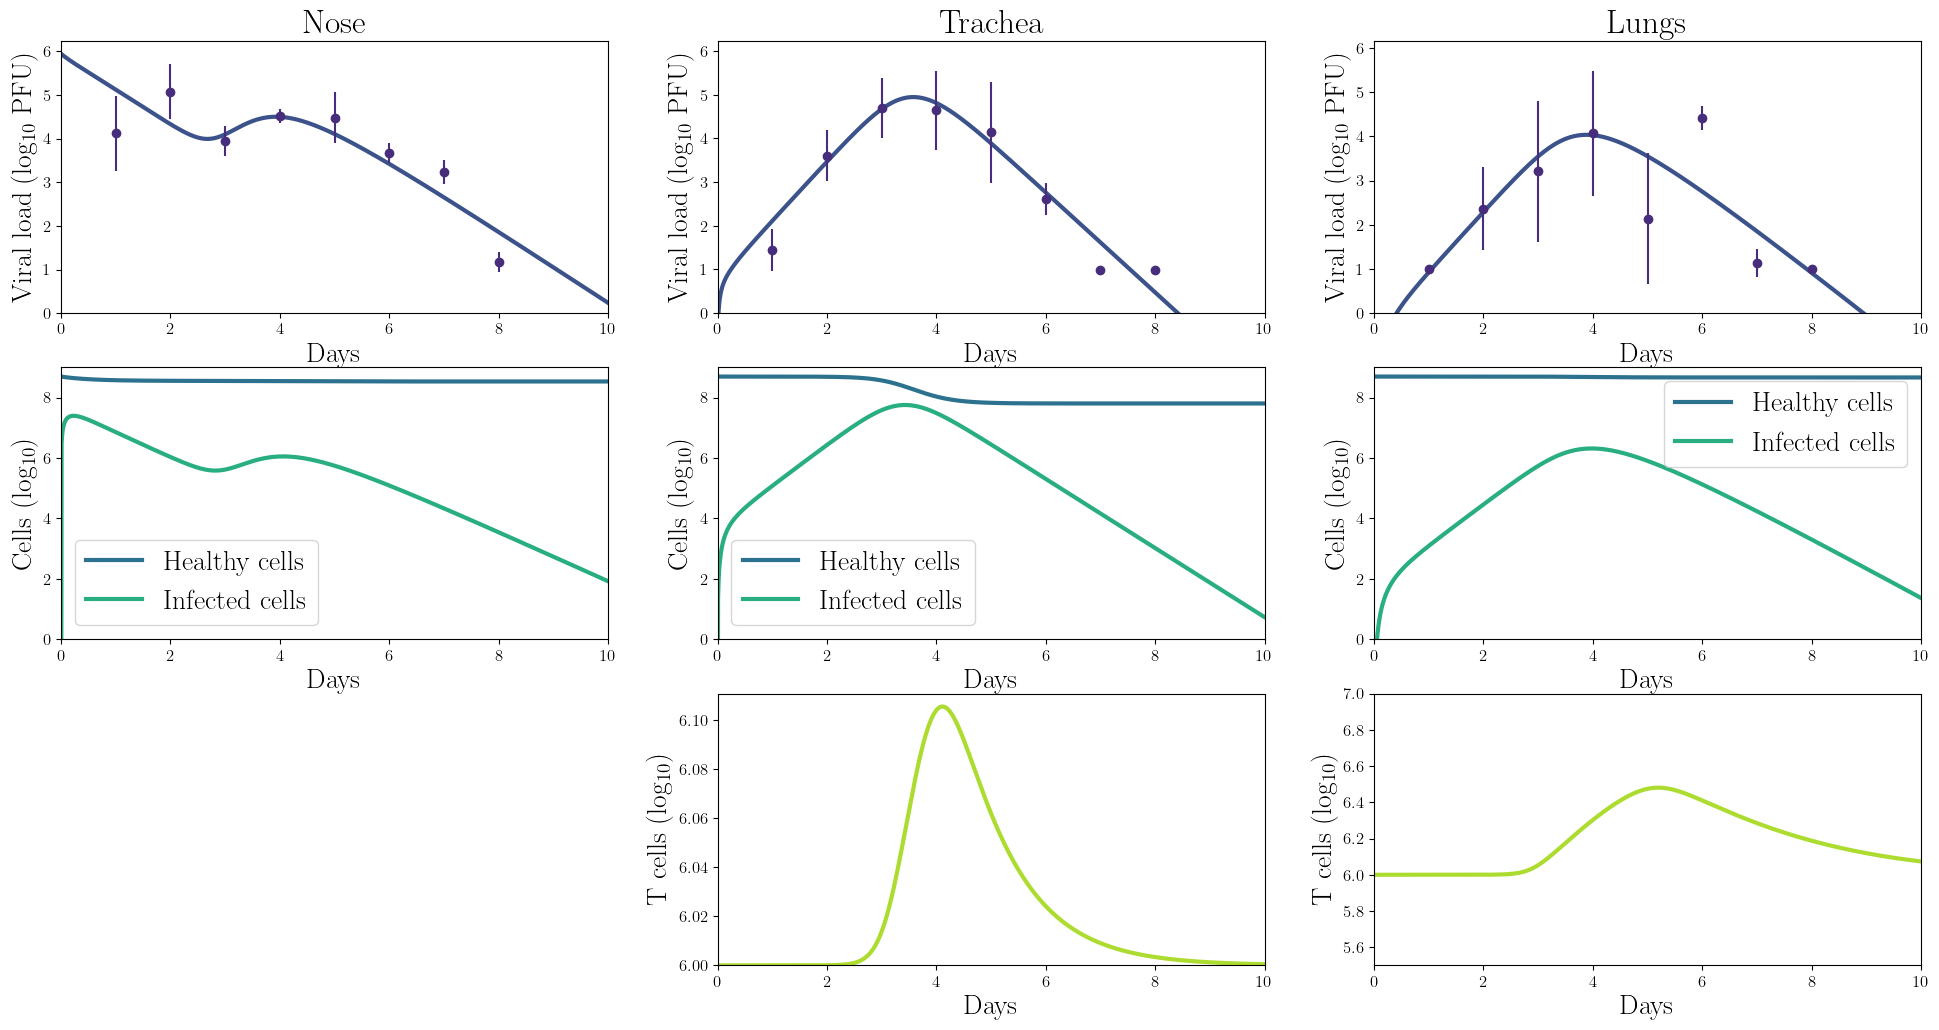

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24,12), facecolor='white')

# Nose
axs[0,0].set_title('Nose')
axs[0,0].plot(tt, safeLog10(VV1), lw=3, color=palette[1])
axs[0,0].errorbar(x=df['Day'], y=df['nose'], yerr=df['stdN'], fmt='o', color=palette[0])
axs[0,0].set_ylim((0))
axs[0,0].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,0].plot(tt, safeLog10(UU1), lw=3, color=palette[2], label='Healthy cells')
axs[1,0].plot(tt, safeLog10(II1), lw=3, color=palette[4], label='Infected cells')
axs[1,0].set_ylim((0, 9))
axs[1,0].set_ylabel('Cells (log$_{10}$)')
axs[1,0].legend()

fig.delaxes(axs[2,0])

# Trachea
axs[0,1].set_title('Trachea')
axs[0,1].plot(tt, safeLog10(VV2), lw=3, color=palette[1])
axs[0,1].errorbar(df['Day'], df['trachea'], yerr=df['stdT'], fmt='o', color=palette[0])
axs[0,1].set_ylim((0))
axs[0,1].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,1].plot(tt, safeLog10(UU2), lw=3, color=palette[2], label='Healthy cells')
axs[1,1].plot(tt, safeLog10(II2), lw=3, color=palette[4], label='Infected cells')
axs[1,1].set_ylim((0, 9))
axs[1,1].set_ylabel('Cells (log$_{10}$)')
axs[1,1].legend()

axs[2,1].plot(tt, safeLog10(TT2), lw=3, color=palette[6])
axs[2,1].set_ylim((6))
axs[2,1].set_ylabel('T cells (log$_{10}$)')

# Lungs
axs[0,2].set_title('Lungs')
axs[0,2].plot(tt, safeLog10(VV3), lw=3, color=palette[1])
axs[0,2].errorbar(df['Day'], df['lung'], yerr=df['stdL'], fmt='o', color=palette[0])
axs[0,2].set_ylim((0))
axs[0,2].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,2].plot(tt, safeLog10(UU3), lw=3, color=palette[2], label='Healthy cells')
axs[1,2].plot(tt, safeLog10(II3), lw=3, color=palette[4], label='Infected cells')
axs[1,2].set_ylim((0, 9))
axs[1,2].set_ylabel('Cells (log$_{10}$)')
axs[1,2].legend()

# rect1 = plt.Rectangle((dfCD8['Day'][0] - 0.5, safeLog10(dfCD8['cd8'][0]) - 0.25), 1, 0.5, fc=palette[7], alpha = 0.5)
# rect2 = plt.Rectangle((dfCD8['Day'][1] - 0.5, safeLog10(dfCD8['cd8'][1]) - 0.25), 1, 0.5, fc=palette[7], alpha = 0.5)
# rect3 = plt.Rectangle((dfCD8['Day'][2] - 0.5, safeLog10(dfCD8['cd8'][2]) - 0.25), 1, 0.5, fc=palette[7], alpha = 0.5)
# rect4 = plt.Rectangle((dfCD8['Day'][3] - 0.5, safeLog10(dfCD8['cd8'][3]) - 0.25), 1, 0.5, fc=palette[7], alpha = 0.5)
# axs[2,2].add_patch(rect1)
# axs[2,2].add_patch(rect2)
# axs[2,2].add_patch(rect3)
# axs[2,2].add_patch(rect4)
# axs[2,2].scatter(x=dfCD8['Day'], y=safeLog10(dfCD8['cd8']), color=palette[6], marker='x', s=100, lw=3)
axs[2,2].plot(tt, safeLog10(TT3), lw=3, color=palette[6])
axs[2,2].set_ylim((5.5,7))
axs[2,2].set_ylabel('T cells (log$_{10}$)')

plt.setp(axs, xlim=(0,endDay), xlabel='Days')

# plt.savefig('M3_fit.pdf')

plt.show()

## Model 4:

**Nose**:
$$\dot{U_1} = -\beta_1 U_1 V_1 - \xi_1 U_1 F_1$$
$$\dot{I_1} = \beta_1 U_1 V_1 - \delta_1 I_1$$
$$\dot{R_1} = \xi_1 U_1 F_1$$
$$\dot{V_1} = \rho_1 I_1 - \varsigma_1 V_1 - \gamma_{12}V_1 + \gamma_{21}V_2$$
$$\dot{F_1} = \alpha_1 I_1 - \phi_1 F_1$$

**Trachea**:
$$\dot{U_2} = -\beta_2 U_2 V_2 - \xi_2 U_2 F_2$$
$$\dot{I_2} = \beta_2 U_2 V_2 - \delta_2 I_2 - \psi_2 I_2 T_2$$
$$\dot{R_2} = \xi_2 U_2 F_2$$
$$\dot{V_2} = \rho_2 I_2 - \varsigma_2 V_2 - \gamma_{21}V_2 + \gamma_{12}V_1 - \gamma_{23}V_2 + \gamma_{32}V_3$$
$$\dot{F_2} = \alpha_2 I_2 - \phi_2 F_2$$
$$\dot{T_2} = \eta_2 T_2 \left( \frac{V_2^2}{V_2^2 + \kappa_2^2} \right) - \upsilon_2 T_2 + \upsilon_2 T_0 - \zeta_{23} T_2 + \zeta_{32} T_3$$

**Lungs**:
$$\dot{U_3} = -\beta_3 U_3 V_3 -\xi_3 U_3 F_3$$
$$\dot{I_3} = \beta_3 U_3 V_3 - \delta_3 I_3 - \psi_3 I_3 T_3$$
$$\dot{R_3} = \xi_3 U_3 F_3$$
$$\dot{V_3} = \rho_3 I_3 - \varsigma_3 V_3 - \gamma_{32}V_3 + \gamma_{23}V_2$$
$$\dot{F_3} = \alpha_3 I_3 - \phi_3 F_3$$
$$\dot{T_3} = \eta_3 T_3 \left( \frac{V_3^2}{V_3^2 + \kappa_3^2} \right) - \upsilon_3 T_3 + \upsilon_3 T_0 - \zeta_{32} T_3 + \zeta_{23} T_2$$

In [56]:
params = np.loadtxt('data/bestPars_M4.dat', comments='#')
for i in range(len(parNames)):
    print(f'{parNames[i]} = {params[i]}')

V0 = 5.78088
bet1 = 1.004544e-08
xi1 = 10.0
chi1 = 0.0
del1 = 0.9905251
rho1 = 0.01
sig1 = 1.868894
bet2 = 2.715426e-06
xi2 = 4.0
chi2 = 5.742739e-06
psi2 = 1.0166
del2 = 0.0
rho2 = 1e-06
sig2 = 0.01
eta2 = 0.01
kap2 = 1.348379
ups2 = 1.007973e-06
bet3 = 4.0
xi3 = 0.4425226
chi3 = 3142.987
psi3 = 0.01
del3 = 1e-05
rho3 = 9.979573
sig3 = 0.0
eta3 = 7.078831e-06
kap3 = 0.8064204
ups3 = 0.01
gam12 = 2.346833
gam21 = 9.21219e-06
gam23 = 4.0
gam32 = 3.209437
zet23 = 7704.368
zet32 = 0.2474528


In [58]:
def model4(y, t, params):
    p = unpack_params(params)

    T20 = 1e6
    T30 = 1e6
    
    U1, I1, R1, V1, F1, U2, I2, R2, V2, F2, T2, U3, I3, R3, V3, F3, T3 = y

    dU1 = -p['bet1']*U1*V1 - p['xi1']*U1*F1
    dI1 = p['bet1']*U1*V1 - p['del1']*I1
    dR1 = p['xi1']*U1*F1
    dV1 = p['rho1']*I1 - p['sig1']*V1 - p['gam12']*V1 + p['gam21']*V2
    dF1 = p['alp1']*I1 - p['phi1']*F1
    
    dU2 = -p['bet2']*U2*V2 - p['xi2']*U2*F2
    dI2 = p['bet2']*U2*V2 - p['psi2']*I2*T2 - p['del2']*I2
    dR2 = p['xi2']*U2*F2
    dV2 = p['rho2']*I2 - p['sig2']*V2 - p['gam21']*V2 + p['gam12']*V1 - p['gam23']*V2 + p['gam32']*V3
    dF2 = p['alp2']*I2 - p['phi2']*F2
    dT2 = p['eta2']*T2*(V2**2/(V2**2 + p['kap2']**2)) - p['ups2']*T2 + p['ups2']*T30 - p['zet23']*T2 + p['zet32']*T3
    
    dU3 = -p['bet3']*U3*V3 - p['xi3']*U3*F3
    dI3 = p['bet3']*U3*V3 - p['psi3']*I3*T3 - p['del3']*I3
    dR3 = p['xi3']*U3*F3
    dV3 = p['rho3']*I3 - p['sig3']*V3 - p['gam32']*V3 + p['gam23']*V2
    dF3 = p['alp3']*I3 - p['phi3']*F3
    dT3 = p['eta3']*T3*(V3**2/(V3**2 + p['kap3']**2)) - p['ups3']*T3 + p['ups3']*T30 - p['zet32']*T3 + p['zet23']*T2
    
    return [dU1, dI1, dR1, dV1, dF1, dU2, dI2, dR2, dV2, dF2, dT2, dU3, dI3, dR3, dV3, dF3, dT3]

In [59]:
U10, U20, U30 = 5e8, 5e8, 5e8
I10, I20, I30 = 0.0, 0.0, 0.0
R10, R20, R30 = 0.0, 0.0, 0.0
V10, V20, V30 = 10**params[0], 0.0, 0.0
F10, F20, F30 = 0.0, 0.0, 0.0
T20, T30 = 1e6, 1e6
initState = [U10, I10, R10, V10, F10, U20, I20, R20, V20, F20, T20, U30, I30, R30, V30, F30, T30]
    
timeStep = 0.1
endDay = 10
tt = np.arange(0, endDay, timeStep)

levels = odeint(model4, initState, tt, args=(params,))

UU1 = levels[:,0]
II1 = levels[:,1]
RR1 = levels[:,2]
VV1 = levels[:,3]
FF1 = levels[:,4]

UU2 = levels[:,5]
II2 = levels[:,6]
RR2 = levels[:,7]
VV2 = levels[:,8]
FF2 = levels[:,9]
TT2 = levels[:,10]

UU3 = levels[:,11]
II3 = levels[:,12]
RR3 = levels[:,13]
VV3 = levels[:,14]
FF3 = levels[:,15]
TT3 = levels[:,16]

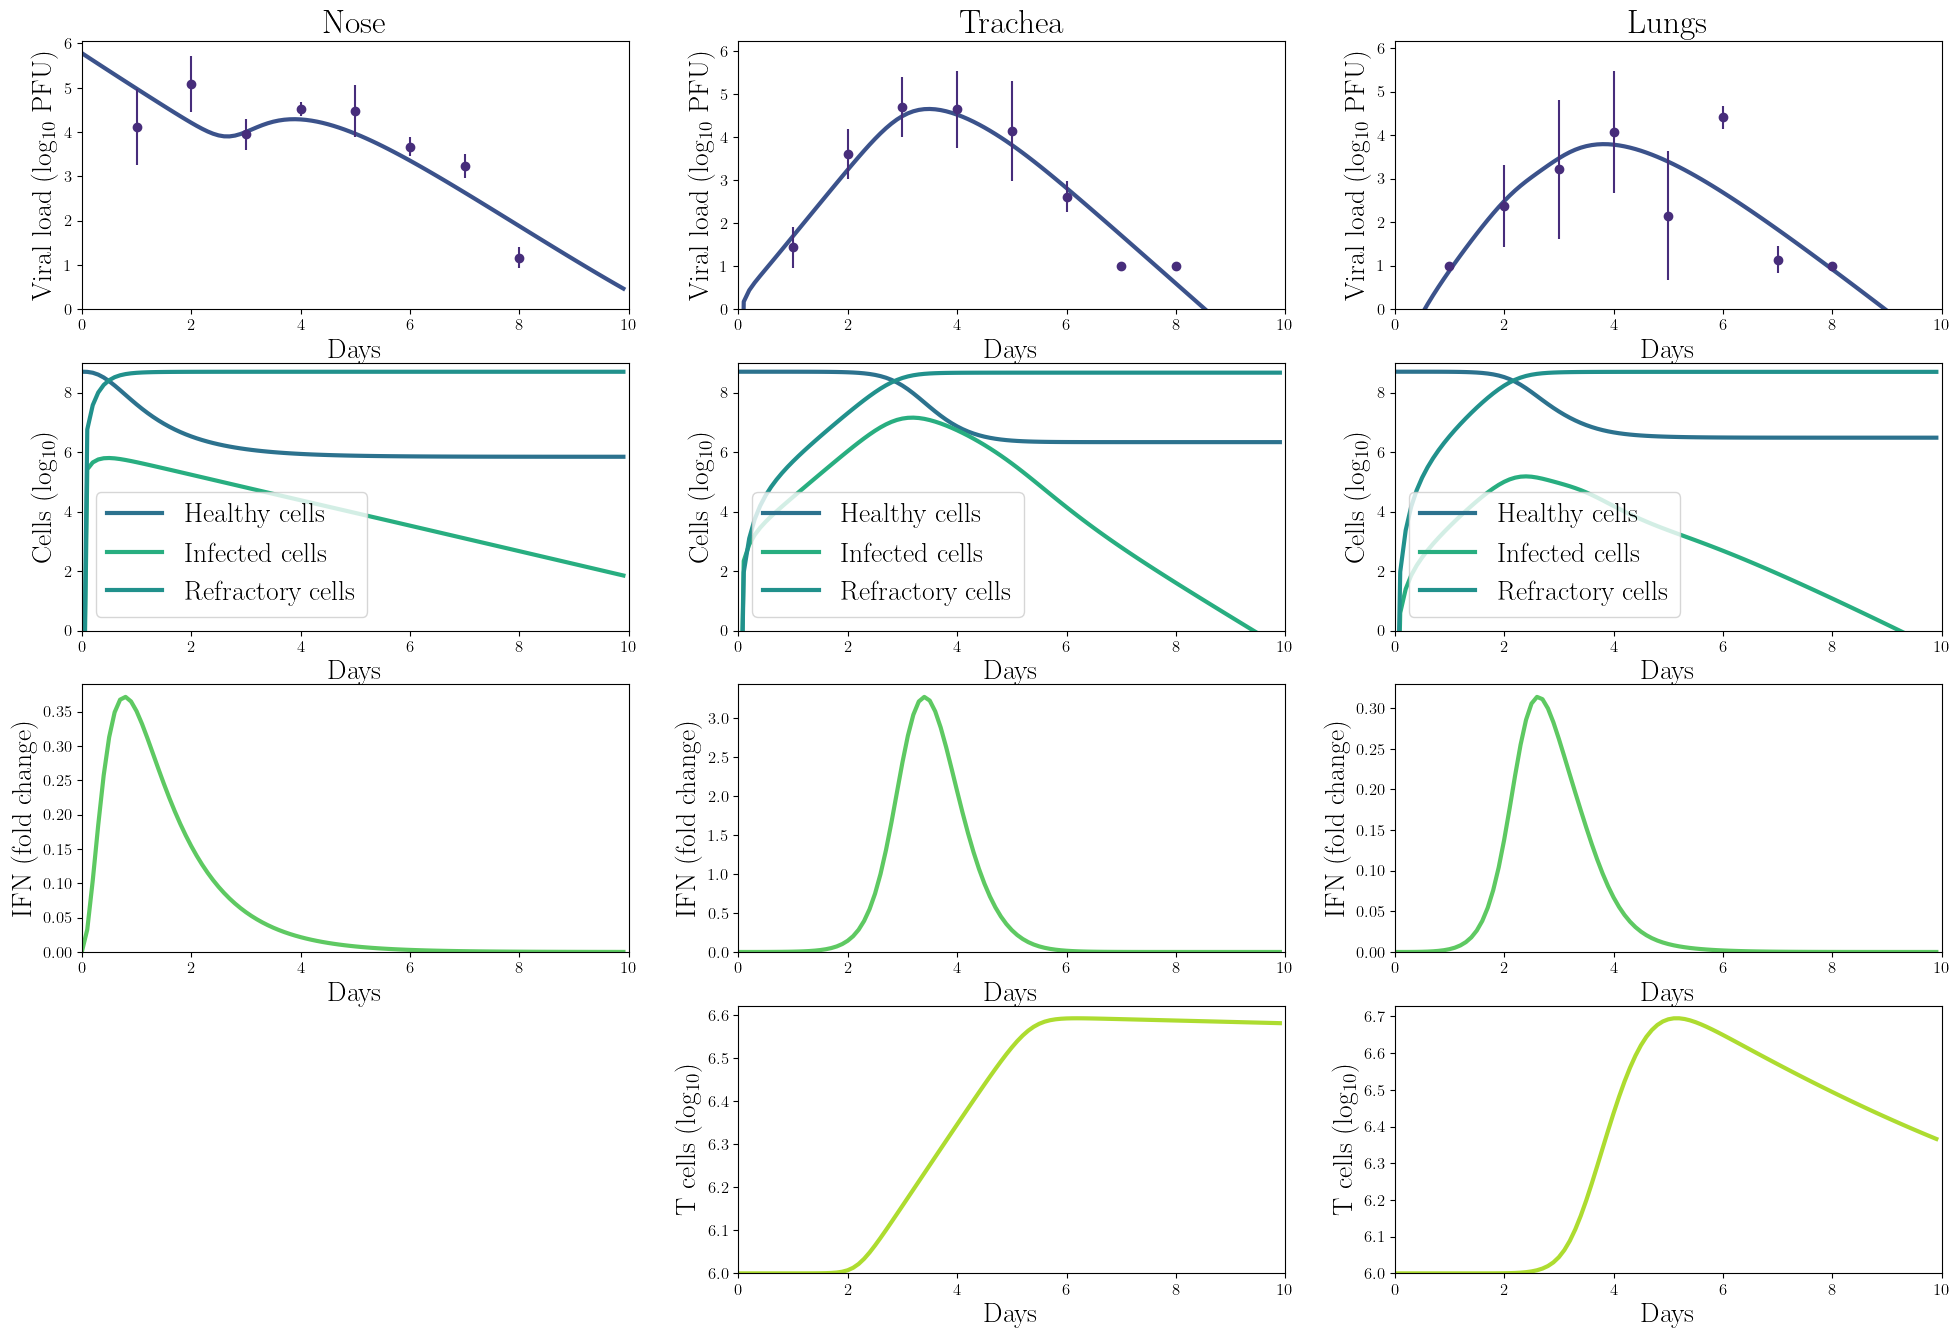

In [60]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')

# Nose
axs[0,0].set_title('Nose')
axs[0,0].plot(tt, safeLog10(VV1), lw=3, color=palette[1])
axs[0,0].errorbar(x=df['Day'], y=df['nose'], yerr=df['stdN'], fmt='o', color=palette[0])
axs[0,0].set_ylim((0))
axs[0,0].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,0].plot(tt, safeLog10(UU1), lw=3, color=palette[2], label='Healthy cells')
axs[1,0].plot(tt, safeLog10(II1), lw=3, color=palette[4], label='Infected cells')
axs[1,0].plot(tt, safeLog10(RR1), lw=3, color=palette[3], label='Refractory cells')
axs[1,0].set_ylim((0, 9))
axs[1,0].set_ylabel('Cells (log$_{10}$)')
axs[1,0].legend()

axs[2,0].plot(tt, FF1, lw=3, color=palette[5])
axs[2,0].set_ylim((0))
axs[2,0].set_ylabel('IFN (fold change)')

fig.delaxes(axs[3,0])

# Trachea
axs[0,1].set_title('Trachea')
axs[0,1].plot(tt, safeLog10(VV2), lw=3, color=palette[1])
axs[0,1].errorbar(df['Day'], df['trachea'], yerr=df['stdT'], fmt='o', color=palette[0])
axs[0,1].set_ylim((0))
axs[0,1].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,1].plot(tt, safeLog10(UU2), lw=3, color=palette[2], label='Healthy cells')
axs[1,1].plot(tt, safeLog10(II2), lw=3, color=palette[4], label='Infected cells')
axs[1,1].plot(tt, safeLog10(RR2), lw=3, color=palette[3], label='Refractory cells')
axs[1,1].set_ylim((0, 9))
axs[1,1].set_ylabel('Cells (log$_{10}$)')
axs[1,1].legend()

axs[2,1].plot(tt, FF2, lw=3, color=palette[5])
axs[2,1].set_ylim((0))
axs[2,1].set_ylabel('IFN (fold change)')

axs[3,1].plot(tt, safeLog10(TT2), lw=3, color=palette[6])
axs[3,1].set_ylim((6))
axs[3,1].set_ylabel('T cells (log$_{10}$)')

# Lungs
axs[0,2].set_title('Lungs')
axs[0,2].plot(tt, safeLog10(VV3), lw=3, color=palette[1])
axs[0,2].errorbar(df['Day'], df['lung'], yerr=df['stdL'], fmt='o', color=palette[0])
axs[0,2].set_ylim((0))
axs[0,2].set_ylabel('Viral load (log$_{10}$ PFU)')

axs[1,2].plot(tt, safeLog10(UU3), lw=3, color=palette[2], label='Healthy cells')
axs[1,2].plot(tt, safeLog10(II3), lw=3, color=palette[4], label='Infected cells')
axs[1,2].plot(tt, safeLog10(RR3), lw=3, color=palette[3], label='Refractory cells')
axs[1,2].set_ylim((0, 9))
axs[1,2].set_ylabel('Cells (log$_{10}$)')
axs[1,2].legend()

axs[2,2].plot(tt, FF3, lw=3, color=palette[5])
axs[2,2].set_ylim((0))
axs[2,2].set_ylabel('IFN (fold change)')

axs[3,2].plot(tt, safeLog10(TT3), lw=3, color=palette[6])
axs[3,2].set_ylim((6))
axs[3,2].set_ylabel('T cells (log$_{10}$)')

plt.setp(axs, xlim=(0,endDay), xlabel='Days')

# plt.savefig('M4_fit.pdf')

plt.show()